# PKPD 102: Pharmacodynamics and Direct Effect Models

This notebook demonstrates how to link drug concentration (PK) to drug effect (PD) using a direct inhibitory Emax model. We'll simulate an IV bolus dose, compute the concentration-time profile, and show how the effect responds as concentration declines.

## Import libraries

We need NumPy for array operations and `solve_ivp` from SciPy to numerically integrate the pharmacokinetic differential equation.

In [4]:
import numpy as np
from scipy.integrate import solve_ivp

## Define PK parameters and the differential equation

For an IV bolus (instantaneous injection), the drug goes directly into the central compartment. The concentration then declines exponentially according to first-order elimination: dC/dt = -(CL/V)·C.

We also set up the pharmacodynamic parameters:
- **E₀**: baseline effect (without drug)
- **Emax**: maximum possible effect change
- **EC₅₀**: concentration producing 50% of maximum effect

In [5]:
CL, V = 5.0, 50.0            # L/h, L
E0, Emax, EC50 = 90, 65, 0.8 # effect units and concentration units

def pk_rhs(t, y):
    C = y[0]
    return [-(CL / V) * C]


## Define the inhibitory Emax model and dose

The **inhibitory Emax** model describes how the drug *decreases* an effect (like suppressing a biomarker or inhibiting an enzyme). As concentration increases, the effect drops from baseline E₀:

$$E(C) = E_0 - \frac{E_{\max} \cdot C}{EC_{50} + C}$$

At C = 0, effect equals E₀. As C → ∞, effect approaches E₀ - Emax. The EC₅₀ determines how quickly the curve bends.

We'll simulate a 200 mg IV bolus dose.

In [7]:
def inhibitory_emax(C):
    return E0 - (Emax * C) / (EC50 + C)

dose = 200.0                 # mg IV bolus


## Solve the PK equation and compute the effect-time profile

1. **Calculate initial concentration**: For an IV bolus, C₀ = dose/V (the entire dose instantly appears in the central compartment)
2. **Integrate the ODE**: `solve_ivp` numerically solves dC/dt = -(CL/V)·C from t=0 to t=12 hours
3. **Evaluate at a time grid**: We create 100 evenly spaced time points and extract concentration at each
4. **Apply the PD model**: Pass the concentration array through the inhibitory Emax function to get effect over time

In [8]:
C0 = dose / V
sol = solve_ivp(pk_rhs, [0, 12], [C0], dense_output=True)
t_grid = np.linspace(0, 12, 100)
C = sol.sol(t_grid)[0]
effect = inhibitory_emax(C)

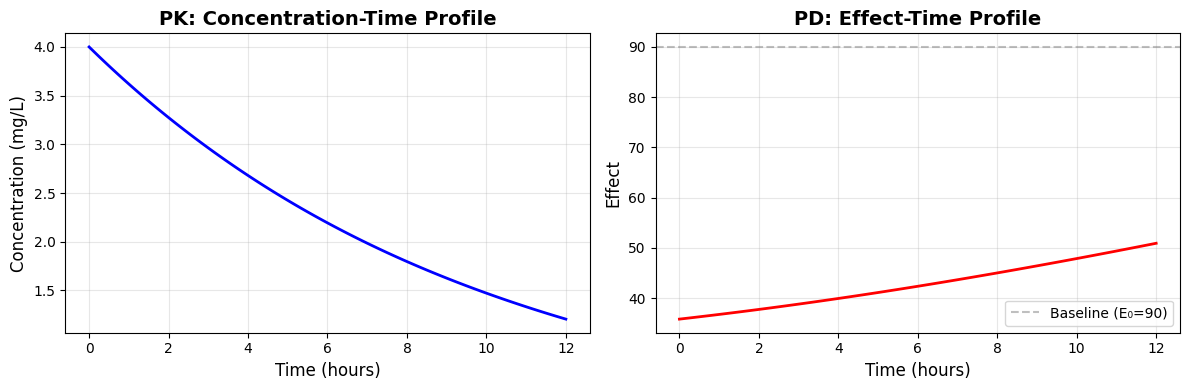

In [10]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot concentration vs time
ax1.plot(t_grid, C, 'b-', linewidth=2)
ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('Concentration (mg/L)', fontsize=12)
ax1.set_title('PK: Concentration-Time Profile', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot effect vs time
ax2.plot(t_grid, effect, 'r-', linewidth=2)
ax2.axhline(y=E0, color='gray', linestyle='--', alpha=0.5, label=f'Baseline (E₀={E0})')
ax2.set_xlabel('Time (hours)', fontsize=12)
ax2.set_ylabel('Effect', fontsize=12)
ax2.set_title('PD: Effect-Time Profile', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualize the results

Now we can plot both the concentration-time curve (PK) and the effect-time curve (PD) to see how they relate. As concentration declines exponentially, the inhibitory effect wanes and the measure returns toward baseline E₀.